In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image

In [38]:
# Установка параметров
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_CLASSES = 21
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BASE_DIR = os.getcwd()

In [3]:
class CustomDataset(Dataset):   
    def __init__(self, images, labels, transform=None, target_transform=None):
        super().__init__()
        self.images_dir = images
        self.labels_dir = labels
        self.transform = transform
        self.target_transform = target_transform
        
        # Get list of image files
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load corresponding label file
        label_path = os.path.join(self.labels_dir, img_name.rsplit('.', 1)[0] + '.txt')
        
        # Parse YOLO format label file
        label = torch.zeros(NUM_CLASSES)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    label[class_id] = 1.0  # Convert to one-hot encoding
                    
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [4]:
# Определение преобразований данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Загрузка данных
train_dataset = CustomDataset(images=BASE_DIR + '/road-signs-2/train/images',
                              labels=BASE_DIR + '/road-signs-2/train/labels',
                              transform=transform
)

val_dataset = CustomDataset(images=BASE_DIR + '/road-signs-2/valid/images',
                              labels=BASE_DIR + '/road-signs-2/valid/labels',
                              transform=transform
)


train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [5]:
# Загрузка модели ResNet50
model = models.resnet50(pretrained=True)
# Изменение последнего слоя для нашего количества классов
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

c:\Users\Spidrre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Spidrre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Функция для обучения одной эпохи
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader):

        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        
        running_loss += loss.item()
        # Get max value indices and create one-hot encoded tensor
        _, max_indices = outputs.max(1)
        predicted = torch.zeros_like(outputs)
        predicted.scatter_(1, max_indices.unsqueeze(1), 1.0)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(dataloader), correct / total


# Функция для валидации
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, max_indices = outputs.max(1)
            predicted = torch.zeros_like(outputs)
            predicted.scatter_(1, max_indices.unsqueeze(1), 1.0)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            

    
    return running_loss / len(dataloader), correct / total

In [39]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Списки для хранения метрик
train_losses = []
train_acc = []
val_losses = []
val_acc = []

# Основной цикл обучения
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    
    # Обучение
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    
    # Валидация
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/50


100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Train Loss: 0.0229, Train Acc: 20.99%
Val Loss: 0.9265, Val Acc: 20.68%
Epoch 2/50


100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Train Loss: 0.0033, Train Acc: 21.00%
Val Loss: 0.8982, Val Acc: 20.70%
Epoch 3/50


100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Train Loss: 0.0032, Train Acc: 21.00%
Val Loss: 0.8656, Val Acc: 20.69%
Epoch 4/50


100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Train Loss: 0.0017, Train Acc: 21.00%
Val Loss: 0.8439, Val Acc: 20.70%
Epoch 5/50


100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Train Loss: 0.0010, Train Acc: 21.00%
Val Loss: 0.8105, Val Acc: 20.69%
Epoch 6/50


100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Train Loss: 0.0010, Train Acc: 21.00%
Val Loss: 0.7790, Val Acc: 20.70%
Epoch 7/50


100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Train Loss: 0.0010, Train Acc: 21.00%
Val Loss: 0.7822, Val Acc: 20.70%
Epoch 8/50


100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Train Loss: 0.0006, Train Acc: 21.00%
Val Loss: 0.7725, Val Acc: 20.71%
Epoch 9/50


100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Train Loss: 0.0003, Train Acc: 21.00%
Val Loss: 0.9174, Val Acc: 20.69%
Epoch 10/50


100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Train Loss: 0.0003, Train Acc: 21.00%
Val Loss: 0.8532, Val Acc: 20.70%
Epoch 11/50


100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Train Loss: 0.0003, Train Acc: 21.00%
Val Loss: 0.8288, Val Acc: 20.70%
Epoch 12/50


100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Train Loss: 0.0017, Train Acc: 21.00%
Val Loss: 0.8607, Val Acc: 20.70%
Epoch 13/50


100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Train Loss: 0.0008, Train Acc: 21.00%
Val Loss: 0.8803, Val Acc: 20.68%
Epoch 14/50


100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Train Loss: 0.0006, Train Acc: 21.00%
Val Loss: 0.8516, Val Acc: 20.70%
Epoch 15/50


100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Train Loss: 0.0004, Train Acc: 21.00%
Val Loss: 0.8858, Val Acc: 20.70%
Epoch 16/50


100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Train Loss: 0.0004, Train Acc: 21.00%
Val Loss: 0.8964, Val Acc: 20.69%
Epoch 17/50


100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Train Loss: 0.0005, Train Acc: 21.00%
Val Loss: 0.8631, Val Acc: 20.71%
Epoch 18/50


100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.9045, Val Acc: 20.69%
Epoch 19/50


100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.8662, Val Acc: 20.71%
Epoch 20/50


100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.8739, Val Acc: 20.71%
Epoch 21/50


100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Train Loss: 0.0003, Train Acc: 21.00%
Val Loss: 0.8930, Val Acc: 20.71%
Epoch 22/50


100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.9243, Val Acc: 20.70%
Epoch 23/50


100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.8778, Val Acc: 20.69%
Epoch 24/50


100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.8788, Val Acc: 20.70%
Epoch 25/50


100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.9124, Val Acc: 20.70%
Epoch 26/50


100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9709, Val Acc: 20.69%
Epoch 27/50


100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9315, Val Acc: 20.70%
Epoch 28/50


100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.9517, Val Acc: 20.70%
Epoch 29/50


100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9488, Val Acc: 20.70%
Epoch 30/50


100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9768, Val Acc: 20.71%
Epoch 31/50


100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9382, Val Acc: 20.70%
Epoch 32/50


100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9673, Val Acc: 20.70%
Epoch 33/50


100%|██████████| 16/16 [00:02<00:00,  7.23it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9651, Val Acc: 20.70%
Epoch 34/50


100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.9870, Val Acc: 20.69%
Epoch 35/50


100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.8896, Val Acc: 20.71%
Epoch 36/50


100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9228, Val Acc: 20.69%
Epoch 37/50


100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9350, Val Acc: 20.69%
Epoch 38/50


100%|██████████| 16/16 [00:02<00:00,  7.26it/s]


Train Loss: 0.0000, Train Acc: 21.00%
Val Loss: 1.0505, Val Acc: 20.69%
Epoch 39/50


100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 1.0295, Val Acc: 20.70%
Epoch 40/50


100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9968, Val Acc: 20.70%
Epoch 41/50


100%|██████████| 16/16 [00:02<00:00,  7.25it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9273, Val Acc: 20.72%
Epoch 42/50


100%|██████████| 16/16 [00:02<00:00,  7.19it/s]


Train Loss: 0.0000, Train Acc: 21.00%
Val Loss: 0.9559, Val Acc: 20.71%
Epoch 43/50


100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.9529, Val Acc: 20.70%
Epoch 44/50


100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.7633, Val Acc: 20.71%
Epoch 45/50


100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Train Loss: 0.0002, Train Acc: 21.00%
Val Loss: 0.7437, Val Acc: 20.70%
Epoch 46/50


100%|██████████| 16/16 [00:02<00:00,  7.30it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.7928, Val Acc: 20.72%
Epoch 47/50


100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.8239, Val Acc: 20.71%
Epoch 48/50


100%|██████████| 16/16 [00:02<00:00,  7.25it/s]


Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.8048, Val Acc: 20.71%
Epoch 49/50


100%|██████████| 16/16 [00:02<00:00,  7.26it/s]


Train Loss: 0.0000, Train Acc: 21.00%
Val Loss: 0.7908, Val Acc: 20.70%
Epoch 50/50


100%|██████████| 16/16 [00:02<00:00,  7.19it/s]

Train Loss: 0.0001, Train Acc: 21.00%
Val Loss: 0.7901, Val Acc: 20.72%


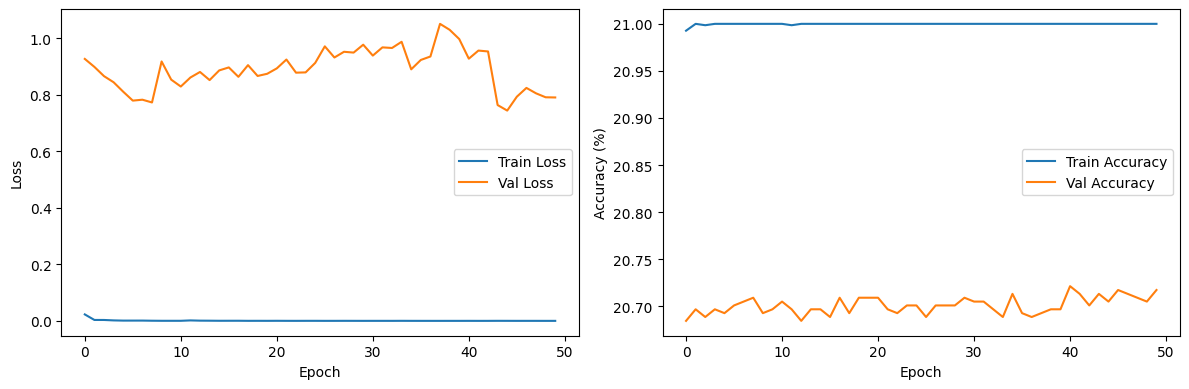

In [40]:
# Построение графиков
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# Сохранение модели
torch.save(model.state_dict(), 'resnet50_traffic_signs.pth')

In [43]:
# Экспорт модели в формат ONNX
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).cuda()  # Создаем тестовый тензор на GPU
torch.onnx.export(model,                    # Модель для экспорта
                 dummy_input,               # Тестовый входной тензор
                 'resnet50_traffic_signs.onnx',  # Путь для сохранения
                 export_params=True,        # Сохранить веса модели
                 opset_version=11,          # Версия ONNX
                 input_names=['input'],     # Имя входного тензора
                 output_names=['output'],   # Имя выходного тензора
                 dynamic_axes={'input': {0: 'batch_size'},    # Динамические оси
                             'output': {0: 'batch_size'}})
print('Модель успешно экспортирована в формат ONNX')


Модель успешно экспортирована в формат ONNX


In [44]:
# Экспорт модели в формат pt
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save('resnet50_traffic_signs.pt')
print('Модель успешно экспортирована в формат PT')


Модель успешно экспортирована в формат TorchScript
